In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gc
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import sys

sys.path.append(r"/home/e.millan/Documents/Stage2020-Nageurs-actifs-proche-de-parois-deformable/PurePython")
from OverdampedLangevin3D import Langevin3D
from InertialLangevin3D import InertialLangevin3D
from RigidWallOverdampedLangevin3D import RigidWallOverdampedLangevin3D 
from RigidWall_InertialLangevin3D import RigidWallInertialLangevin3D 

from mpl_toolkits import mplot3d
from scipy.signal import correlate
from scipy.optimize import curve_fit

import sys
import glob
from tqdm import tqdm
from scipy.optimize import curve_fit
from tqdm import trange
import matplotlib as mpl
mpl.rcParams['figure.dpi']=140
mpl.rcParams['xtick.direction']="in"
mpl.rcParams['ytick.direction']="in"
mpl.rcParams['lines.markeredgecolor']="k"
mpl.rcParams['lines.markeredgewidth']=0.2
mpl.rcParams['lines.markersize'] = 10
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=True)
rc("xtick", labelsize=20)
rc("ytick", labelsize=20)
from sys import getsizeof

In [2]:
sys.path.append(r"/home/e.millan/Documents/Stage2020-Nageurs-actifs-proche-de-parois-deformable/Results")
from Functions_Analysis import plot_traj, MSD, PDF, P_z_wall

## 1. Calcul trajectoire

In [3]:
dt = 1e-3
Nt = 1000000
a = 1.5e-6
rho = 1050
r0 = (0., 0., 1.5e-6)


simu = RigidWallOverdampedLangevin3D(dt=dt, Nt=Nt, R=a, rho=rho, x0=r0)
simu.trajectory()

Rs = np.zeros([Nt, 3])

Rs[:,0] = simu.x
Rs[:,1] = simu.y
Rs[:,2] = simu.z

100%|██████████| 999999/999999 [00:17<00:00, 58037.67it/s]


## 2. Plot trajectoire

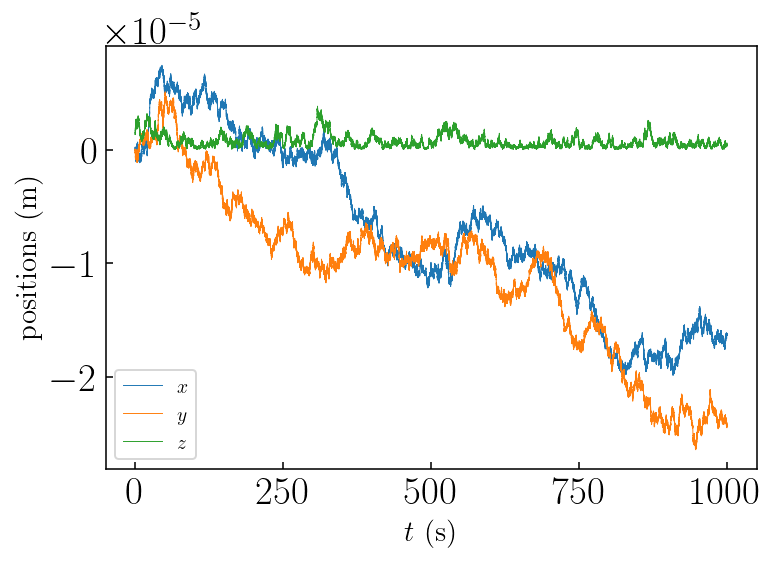

In [4]:
plot_traj(simu.t,Rs)

## 3. plot PDF

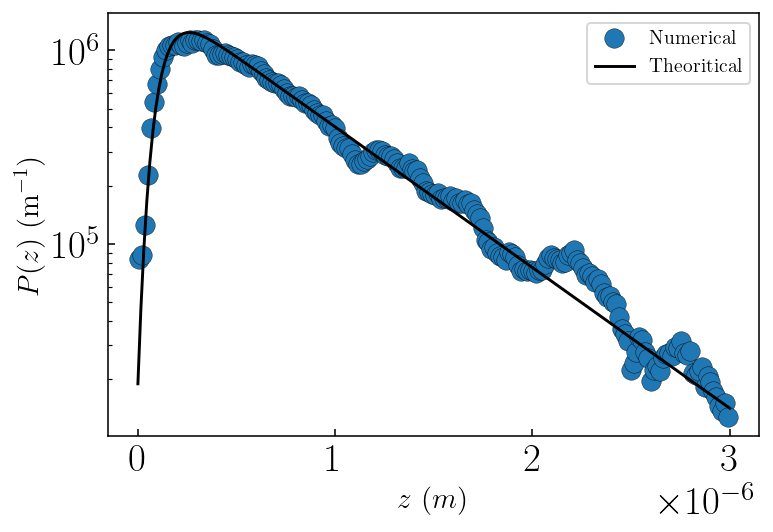

In [5]:
PDF("z", Rs, simu.dt, simu.Nt, lD=simu.lD, lB=simu.lB, space="wall", bins=200)

In [24]:
zth = np.linspace(1e-7, 3e-6, 200)
pdf_theo = P_z_wall(zth, 1, 4.8, simu.lD, simu.lB)
Peq_z = pdf_theo/np.trapz(pdf_theo, zth)

# plt.semilogy(zth, Peq_z)

""" 
    Sur l'axe Z
"""
Dz = (simu.kb*simu.T) / (simu._gamma_z(zth))
mean_Dz_theo = np.trapz(Dz * Peq_z, zth)
print("<Dz>_theo/D_0 = {:.2f}".format(mean_Dz_theo/(simu.kb * simu.T / simu.gamma)))

""" 
    Sur l'axe X
"""
Dx = (simu.kb*simu.T) / (simu._gamma_xy(zth))
mean_Dx_theo = np.trapz(Dx * Peq_z, zth)
print("<Dx>_theo/D_0 = {:.10f}".format(mean_Dx_theo/(simu.kb * simu.T / simu.gamma)))

<Dz>_theo/D_0 = 0.28
<Dx>_theo/D_0 = 0.6028324441


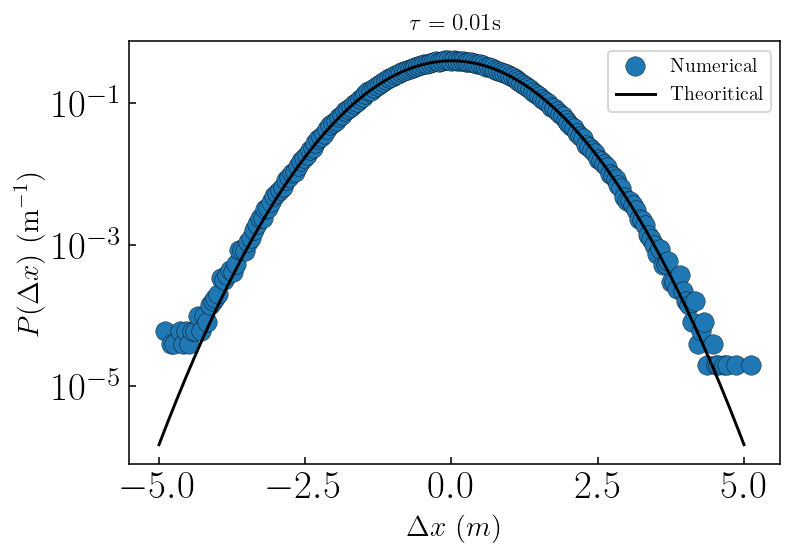

In [25]:
PDF("dx", Rs, simu.dt, simu.Nt, D=mean_Dx_theo, lD=simu.lD, lB=simu.lB, space="wall", bins=200)

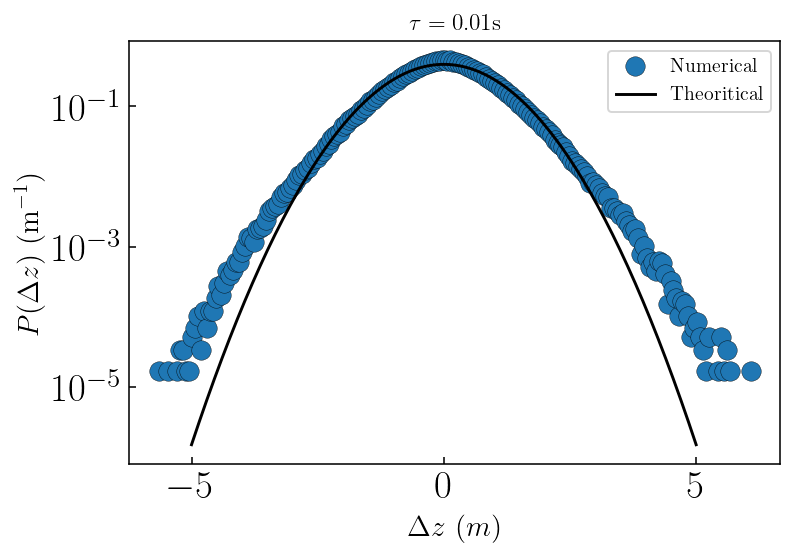

In [26]:
PDF("dz", Rs, simu.dt, simu.Nt, D=mean_Dz_theo, lD=simu.lD, lB=simu.lB, space="wall", bins=200)

## 4. PLot MSD

100%|██████████| 54/54 [00:00<00:00, 413.99it/s]


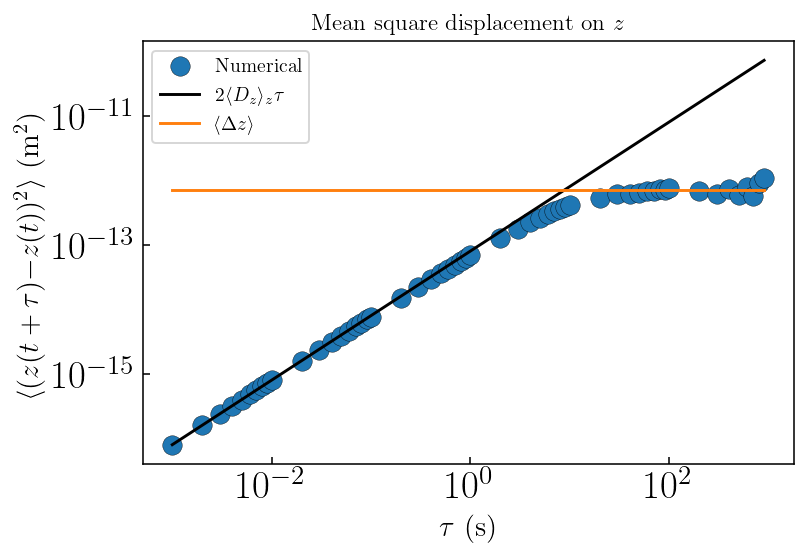

In [27]:
MSD("z", Rs, simu.dt, simu.Nt, D_mean=mean_Dz_theo, lD=simu.lD, lB=simu.lB, space="wall")

## 5. Cumulant ordre 4

\begin{equation}
    C^{(4)} = \frac{1}{4!}\left( \langle z(t)-z(t+\tau) \rangle^4 - 3 \langle (z(t)-z(t+\tau)^2 \rangle^2 \right)
\end{equation}

In [29]:
mean_Dx2_theo = np.trapz(Dx**2*Peq_z, z_hist)
facteur_cumulant = (mean_Dx2_theo - mean_Dx_theo**2)/2
print(facteur_cumulant)

1.8301432079139405e-28


In [30]:
list_dt_c4 = np.array([], dtype=int)
for i in range(len(str(Nt)) - 3):
    # Take just 10 points by decade.
    list_dt_c4 = np.concatenate(
        (
            list_dt_c4,
            np.arange(10 ** i, 10 ** (i + 1), 10 ** i, dtype=int),
        )
    )

In [31]:
NumberOfMSDPoint = len(list_dt_c4)
c4 = np.zeros(NumberOfMSDPoint) #Notre pote, cumulant d'ordre 4
position = Rs[:, 0]
axis = "x"

In [32]:
for k, i in enumerate(tqdm(list_dt_c4)):
    if i == 0:
        c4[k] = 0
        continue
    c4[k] =(np.mean((position[i:]-position[:-i])**4) - 3*(np.mean((position[i:]-position[:-i])**2))**2) * 1/(24)

100%|██████████| 36/36 [00:00<00:00, 48.89it/s]


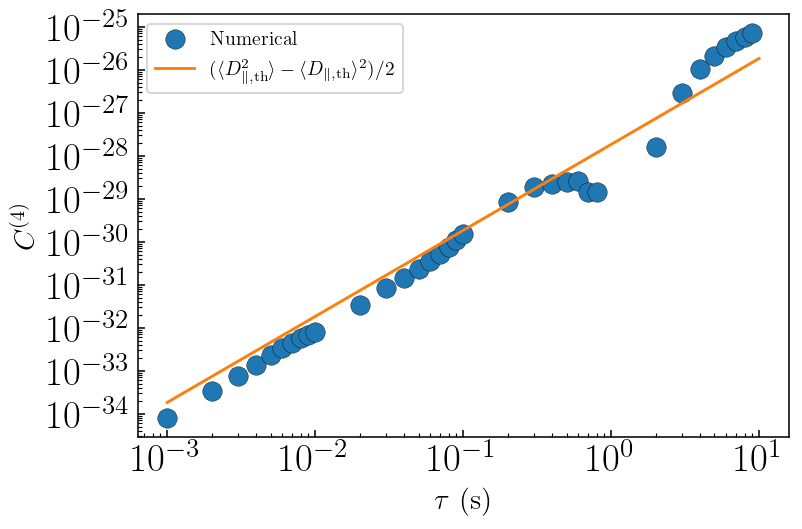

In [33]:
plt.loglog(simu.t[list_dt_c4], c4, "o", label=r"$\mathrm{Numerical}$")
plt.xlabel(r"$\tau$ $(\mathrm{s})$", fontsize=15)
plt.ylabel(r"$C^{(4)}$", fontsize=15)
ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=100)
ax.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())


locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

tth = np.linspace(1e-3,10)
plt.plot(tth, facteur_cumulant* tth**2, label=r"$(\langle D_{\|, \mathrm{th}}^2 \rangle - \langle D_{\|, \mathrm{th}} \rangle^2)/2$")


plt.legend()
plt.show()
